Working on accuracy of the model
We consider 0 in targets and features as missing values. 

So to build a model for every component in the target vector we:
Choose the rows where target componetn is not zeroes, then getting the same rows with the features and
consider this set as a training dataset for this target.
Then choose top X features with the most data. 
   # Open question: how many features to get into the model????
       We choose random sample of targets and then compare sample selection vs. full data selection.
Complete parameters tuning for XGBRegressor with 5 fold gross validation.
Build and save the model for each of ~24000 targets. 
Ways to do it:
1. Get 20000 random sample from original dataset and build models it on.
2. Choose features and make tuning on random sample, but build a model on a full dataset.
3. Build a model on all available data from the big dataset.
   # Open question: how much time will I need in every case to build all models?


# so, I realized that 0 in targets are valid output.
XGBoost handle imbalanced dataset pretty well. So, I guess I reached the end in this thread.

In [64]:
#jupyter notebook --NotebookApp.max_buffer_size=35536870912 
# to run jupyter notebook using more available memory
import os, gc, pickle, scipy.sparse, time, h5py, anndata, hdf5plugin#, lightgbm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
##feature Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
#from sklearn.svm import SVR takes way too long
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
#import scanpy as sc
import anndata
import hdf5plugin
from sys import getsizeof
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import joblib
import h5py
from scipy.sparse import csr_matrix
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import seaborn as sns

data_path = "/home/skovtun/Single cell/Single_cell_data"
metadata = os.path.join(data_path,"metadata.csv")

train_cite_inputs = os.path.join(data_path,"train_cite_inputs.h5")
train_cite_targets = os.path.join(data_path,"train_cite_targets.h5")
test_cite_inputs = os.path.join(data_path,"test_cite_inputs.h5")

train_multi_inputs = os.path.join(data_path,"train_multi_inputs.h5")
train_multi_targets = os.path.join(data_path,"train_multi_targets.h5")
test_multi_inputs = os.path.join(data_path,"test_multi_inputs.h5")

sample_submission = os.path.join(data_path,"sample_submission.csv")
evaluation_ids = os.path.join(data_path,"evaluation_ids.csv")


In [3]:
# Open the h5py file
with h5py.File(train_multi_inputs, 'r') as h5file:
    # Access the dataset within the group
    data = h5file['train_multi_inputs']['block0_values']
    
    # Determine the total number of samples and features
    total_samples, total_features = data.shape
    
    # Set the desired number of samples for the random sample
    desired_samples = 20000  # Adjust as needed

    # Randomly sample row indices
    first_sample_indices = np.sort(np.random.choice(total_samples, size=desired_samples, replace=False))
    sample_cell_id = h5file['train_multi_inputs']['axis1'][first_sample_indices]
    
    data_list1 = []
    indices_list1 = []
    indptr_list1 = [0]  # Initialize with 0
    
    # Iterate over chunks of data to extract and process the sampled rows
    chunk_size = 1000  # Adjust as needed
    for start in range(0, desired_samples, chunk_size):
        end = min(start + chunk_size, desired_samples)
        print(start, end)
        chunk1 = data[first_sample_indices[start:end]]
           
        # Process the chunk, convert to CSR format
        processed_chunk_sparse1 = csr_matrix(chunk1)
            
        # Update indptr and store the data and indices
        indptr_list1.extend(processed_chunk_sparse1.indptr[1:] + indptr_list1[-1])
        data_list1.append(processed_chunk_sparse1.data)
        indices_list1.append(processed_chunk_sparse1.indices)

    
    # Combine the lists into arrays
    values1 = np.concatenate(data_list1)
    indices1 = np.concatenate(indices_list1)
    indptr1 = np.array(indptr_list1)

    # Create the final CSR sparse matrix
    sampled_sparse_matrix1 = csr_matrix((values1, indices1, indptr1), shape=(desired_samples, total_features))
    


0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000


In [4]:
dense_array = sampled_sparse_matrix1.toarray()

The idea is to build a model using only non-nul feature values and target values. 
Consider 0 as missing values. Prediction for feature with missing value would be average of the target
for this feature.
One more idea: to check how model we build using XGBRegressor works on this subset.
And one more idea: to replace values by 1 and check if there is some rules: like two features are both
not null
Another idea: for every feature filter rows that are not zero. Find columns with maximum amount of 
non zero values and use it as a criteria to what features go into the model for this feature.
Not working with the sparse matrices. 
Using sample, that has 20000 rows. Choosing columns, than getting all 100000 rows for these columns
from the initial file.

In [172]:
# Checking negative values to see if we can apply NMF
has_negatives = np.any(dense_array < 0)

In [6]:
Xm_train = h5py.File(train_multi_inputs,'r')
target = h5py.File(train_multi_targets,'r')
y = target['train_multi_targets']['block0_values'][first_sample_indices,:]
# cell_id_train = Xm_train['train_multi_inputs']['axis1']
# cell_id_target = target['train_multi_targets']['axis1']
# t_cell_id_train = tuple(cell_id_train)
# t_cell_id_target = tuple(cell_id_target)
# t_cell_id_target == t_cell_id_train
# #True
# So the lists of cell_id in train_multi_inputs and train_multi_targets are identical. 
# This means we can ignore cell_id and just use row number in the corresponding data tables.

for tartet target = y[:,14096], lets choose only rows when its values are
not zero and try to evaluate how many columns (feautres) have enought non null data
to include in the model.

In [18]:
# In future conver this to function from target number and number of columns to choose, that
#returns X an y for model
# Constructing X and y for model.
target_14096 = y[:,14096]
nonzero_rows_target_14096 = [i for i,x in enumerate(target_14096) if x != 0]
print(len(nonzero_rows_target_14096))
# subsetting dense_array to choose only rows that have non zero target
X_14096 = dense_array[indices_target_14096,:]
# counting number of non zero value in each column
non_zero_column_counts_X_14096 = np.count_nonzero(X_14096, axis=0)
# sorting column number in order of having maximum amount of data is on top
sorted_columns_14096 = np.argsort(non_zero_column_counts_X_14096)[::-1]

top_10_columns_14096 = sorted_columns_14096[:10]
X_14096_train = X_14096[:,top_10_columns_14096]
y_14096_train = target_14096[nonzero_rows_target_14096]

926


In [ ]:
# make it a function, that takes X and y and returns set of best parameters.
start_time = time.time()
# Create an instance of XGBRegressor
xgb_model = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based')
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=3)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.075, 0.1, 0.5],
    'min_child_weight': [1, 3, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [1, 5, 10, 100, 500],
    'reg_lambda': [1, 5, 10, 100, 500]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error',verbose = 3)

# Fit the GridSearchCV instance on the data
grid_search.fit(X_14096_train, y_14096_train)

# Print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the train set
y_pred = best_model.predict(X_14096_train)

# Calculate the mean squared error on the train set
pe = scipy.stats.pearsonr(y_14096_train, y_pred)
print("Pearson Error on test set:", pe)
print("--- %s seconds ---" % (time.time() - start_time))
# Best parameters: {'learning_rate': 0.5, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 10, 'reg_lambda': 500}
# Pearson Error on test set: PearsonRResult(statistic=0.44926779272601136, pvalue=3.3870190701294323e-47)
# --- 498.65297293663025 seconds ---
param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.5],
    #'min_child_weight': [1, 3, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [1, 5, 100],
    'reg_lambda': [1, 5, 100]
}
# Best parameters: {'learning_rate': 0.1, 'reg_alpha': 5, 'reg_lambda': 100}
# Pearson Error on test set: PearsonRResult(statistic=0.554110234076925, pvalue=1.2079427531173894e-75)
# --- 7.867278337478638 seconds ---

I don't understand why grid search on bigger set of values got me worse results.
To get better understanding, I am going to check default values of the classifier with xgb_regressor.get_params().
So, min_child_weight: None. 
It essentially means that this parameter is not constrained, and the algorithm will allow nodes in the tree to continue splitting as long as they lead to a reduction in the loss function, regardless of the number of samples in the node.
So min_cildi_weight is another regularization parameter.

In [ ]:
start_time = time.time()
# Create an instance of XGBRegressor
xgb_model = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based')
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=3)

# Define the parameter grid for GridSearchCV
param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.05, 0.075],
    #'min_child_weight': [1, 3, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [1, 5, 100],
    'reg_lambda': [1, 5, 100]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error',verbose = 3)

# Fit the GridSearchCV instance on the data
grid_search.fit(X_14096_train, y_14096_train)

# Print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the train set
y_pred = best_model.predict(X_14096_train)

# Calculate the pearson correlation on the train set
pe = scipy.stats.pearsonr(y_14096_train, y_pred)
print("Pearson Error on train set:", pe)
print("--- %s seconds ---" % (time.time() - start_time))

# Best parameters: {'learning_rate': 0.1, 'reg_alpha': 5, 'reg_lambda': 100}
# Pearson Error on test set: PearsonRResult(statistic=0.554110234076925, pvalue=1.2079427531173894e-75)
# --- 7.867278337478638 seconds ---

# Best parameters: {'learning_rate': 0.075, 'reg_alpha': 5, 'reg_lambda': 100}
# Pearson Error on test set: PearsonRResult(statistic=0.5011040564865035, pvalue=5.012649187126181e-60)
# --- 26.326497316360474 seconds ---

# so Best parameters: {'learning_rate': 0.075, 'reg_alpha': 5, 'reg_lambda': 100}
# We need to check if they will be the same on the big dataset.
# We need to check if they will be the same on the sample dataset with 30 columns.

In [33]:
# Train the model with the optimal parameters on the sample
xgb_model_14096 = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based',
                        learning_rate = 0.075, reg_alpha = 5, reg_lambda = 100)
xgb_model_14096.fit(X_14096_train, y_14096_train)
y_pred = xgb_model_14096.predict(X_14096_train)
# Calculate the mean squared error on the train set
pe = scipy.stats.pearsonr(y_14096_train, y_pred)
print("Pearson Error on train set:", pe)
#Pearson Error on train set: PearsonRResult(statistic=0.5011040564865035, pvalue=5.012649187126181e-60)

Pearson Error on train set: PearsonRResult(statistic=0.5011040564865035, pvalue=5.012649187126181e-60)


In [29]:
# Get the full data form 14096 target. Or complimentary to 20000 sample data
# first_sample_indices is the list of row indices that were chosen for the first sample
# Creating a boolean mask where True represents indices I want to keep
all_indices = np.arange(0, 105942)
mask = np.ones(105942, dtype=bool)
mask[first_sample_indices] = False
# Use boolean indexing to subset the array
rest_indices = all_indices[mask]
target_test_14096 = target['train_multi_targets']['block0_values'][rest_indices,14096]
# Getting indices of only non null values in target_test_14096
nonzero_rows_target_test_14096 = [i for i,x in enumerate(target_test_14096) if x != 0]
print(len(nonzero_rows_target_test_14096))

4204


In [30]:
# Getting feature data from Xm_train. As we will be using it for analysis of columns,
# we are getting all columns, not only 10 that were used in the model.
with h5py.File(train_multi_inputs, 'r') as h5file:
    # Access the dataset within the group
    data = h5file['train_multi_inputs']['block0_values']
    
    # Determine the total number of samples and features
    total_samples, total_features = data.shape
    
    # Set the desired number of samples for the random sample
    desired_samples = len(nonzero_rows_target_test_14096)  # Adjust as needed

    # Randomly sample row indices
    indices = nonzero_rows_target_test_14096
        
    data_list1 = []
    indices_list1 = []
    indptr_list1 = [0]  # Initialize with 0
    
    # Iterate over chunks of data to extract and process the sampled rows
    chunk_size = 1000  # Adjust as needed
    for start in range(0, desired_samples, chunk_size):
        end = min(start + chunk_size, desired_samples)
        print(start, end)
        chunk1 = data[first_sample_indices[start:end]]
           
        # Process the chunk, convert to CSR format
        processed_chunk_sparse1 = csr_matrix(chunk1)
            
        # Update indptr and store the data and indices
        indptr_list1.extend(processed_chunk_sparse1.indptr[1:] + indptr_list1[-1])
        data_list1.append(processed_chunk_sparse1.data)
        indices_list1.append(processed_chunk_sparse1.indices)

    
    # Combine the lists into arrays
    values1 = np.concatenate(data_list1)
    indices1 = np.concatenate(indices_list1)
    indptr1 = np.array(indptr_list1)

    # Create the final CSR sparse matrix
    sampled_sparse_matrix_14096 = csr_matrix((values1, indices1, indptr1), shape=(desired_samples, total_features))
dense_array_14096 = sampled_sparse_matrix_14096.toarray()    

0 1000
1000 2000
2000 3000
3000 4000
4000 4204


In [34]:
# Check the performance on the part that was not included in the model.
y_14096_test = target_test_14096[nonzero_rows_target_test_14096]
X_14096_test = dense_array_14096[:,top_10_columns_14096]
y_pred = xgb_model_14096.predict(X_14096_test)
# Calculate the mean squared error on the train set
pe = scipy.stats.pearsonr(y_14096_test, y_pred)
print("Pearson Error on test set:", pe)
# Pearson Error on test set: PearsonRResult(statistic=0.01876791177502536, pvalue=0.22374729740634247)
# So, this model doesn't work at all

Pearson Error on test set: PearsonRResult(statistic=0.01876791177502536, pvalue=0.22374729740634247)


In [35]:
# What if we just swap test and train datasets. We train on test and test on train and see how stable resutls are. 
# Train the model with the optimal parameters on the sample
xgb_model_14096_swap = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based',
                        learning_rate = 0.075, reg_alpha = 5, reg_lambda = 100)
xgb_model_14096_swap.fit(X_14096_test, y_14096_test)
y_pred = xgb_model_14096_swap.predict(X_14096_test)
# Calculate the mean squared error on the train set
pe = scipy.stats.pearsonr(y_14096_test, y_pred)
print("Pearson Error on test set that was used for model building:", pe)

y_pred = xgb_model_14096_swap.predict(X_14096_train)
# Calculate the mean squared error on the train set
pe = scipy.stats.pearsonr(y_14096_train, y_pred)
print("Pearson Error on train set that was used for testing:", pe)
# Pearson Error on test set that was used for model building: PearsonRResult(statistic=0.4124272625926005, pvalue=2.246953304531328e-172)
# Pearson Error on train set that was used for testing: PearsonRResult(statistic=0.07917052558489625, pvalue=0.015965299341501427)
# No, clearly, it is not working at all.

Pearson Error on test set that was used for model building: PearsonRResult(statistic=0.4124272625926005, pvalue=2.246953304531328e-172)
Pearson Error on train set that was used for testing: PearsonRResult(statistic=0.07917052558489625, pvalue=0.015965299341501427)


Write a function, that takes X_train, X_test, y_train, y_test and number of columns to choose.

In [38]:
# Check that top 10 columns information wise are the same
# counting number of non zero value in each column
non_zero_column_counts_X_14096_test = np.count_nonzero(dense_array_14096, axis=0)
# sorting column number in order of having maximum amount of data is on top
sorted_columns_X_14096_test = np.argsort(non_zero_column_counts_X_14096_test)[::-1]

top_10_columns_14096 = sorted_columns_14096[:10]
top_10_columns_14096_test = sorted_columns_X_14096_test[:10]
print(top_10_columns_14096)
print(top_10_columns_14096_test)
#[ 86775  97920  55713 221775  76154 134906 153294 128389   3165  80864]
#[153294  86775  97920 221775  55713 134906 224677 128389  76154  80864]
# Very similar, but not identical lists

[ 86775  97920  55713 221775  76154 134906 153294 128389   3165  80864]
[153294  86775  97920 221775  55713 134906 224677 128389  76154  80864]


Let's analyse how much data are in the rows and columns of the dense_array_14096 (4204 rows) and X_14096 (926 rows)

In [60]:
X_14096_all = np.concatenate((dense_array_14096, X_14096), axis=0)
non_zero_count_per_row = np.count_nonzero(X_14096_all, axis=1)
non_zero_count_per_column = np.count_nonzero(X_14096_all, axis=0)

Text(0.5, 1.0, 'Histogram of not null values per cell')

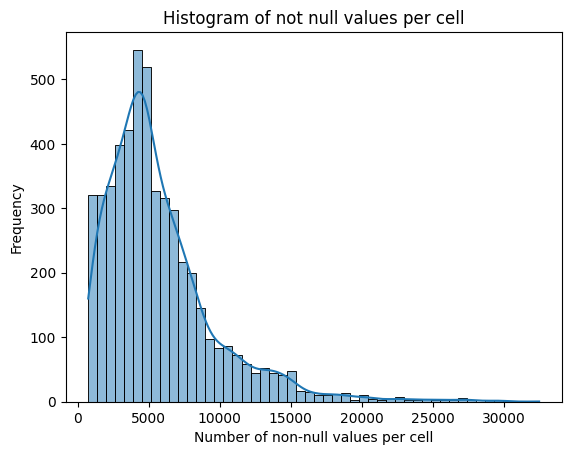

In [65]:
sns.histplot(non_zero_count_per_row, bins=50, kde=True)  # 'bins' controls the number of bins, 'kde' adds a kernel density estimation plot

# Add labels and a title
plt.xlabel("Number of non-null values per cell")
plt.ylabel("Frequency")
plt.title("Histogram of not null values per cell")


In [68]:
non_zero_percent_per_column = np.count_nonzero(X_14096_all, axis=0)/5130*100
non_zero_percent_per_column

array([1.28654971, 0.91617934, 0.27290448, ..., 1.79337232, 0.15594542,
       0.62378168])

Text(0.5, 1.0, 'Histogram of not null values per cell for most filled 5000 features')

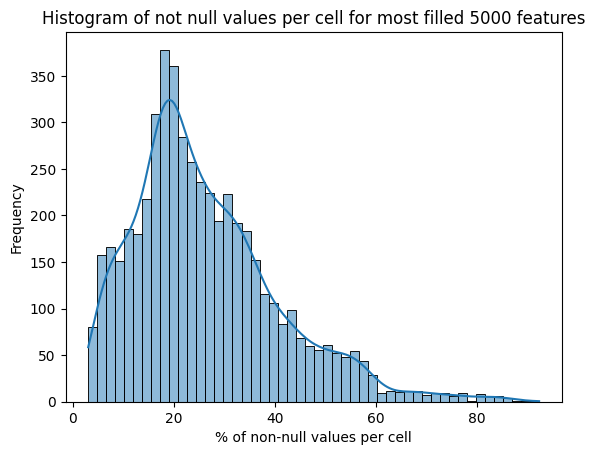

In [76]:
sorted_columns_indices = np.argsort(non_zero_percent_per_column)[::-1]

top_5000_columns = sorted_columns_indices[:5000]
X_14096_top_5000 = X_14096_all[:,top_5000_columns]
non_zero_percent_per_row_5000 = np.count_nonzero(X_14096_top_5000, axis = 1)/5000 * 100
sns.histplot(non_zero_percent_per_row_5000, bins=50, kde=True)  # 'bins' controls the number of bins, 'kde' adds a kernel density estimation plot
# Add labels and a title
plt.xlabel("% of non-null values per cell")
plt.ylabel("Frequency")
plt.title("Histogram of not null values per cell for most filled 5000 features")

Text(0.5, 1.0, 'Histogram of not null values per feature for the most filled 5000 features')

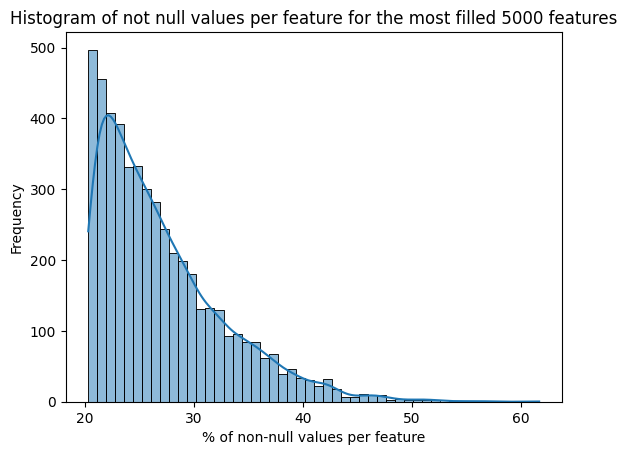

In [77]:
non_zero_percent_per_column_5000 = np.count_nonzero(X_14096_top_5000, axis = 0)/5000 * 100
sns.histplot(non_zero_percent_per_column_5000, bins=50, kde=True)  # 'bins' controls the number of bins, 'kde' adds a kernel density estimation plot
# Add labels and a title
plt.xlabel("% of non-null values per feature")
plt.ylabel("Frequency")
plt.title("Histogram of not null values per feature for the most filled 5000 features")

In [79]:
# what if we do PCA for every target separately? Let's evaluate speed and performance.
# We will use bigger dataset to train and smaller to evaluate.
X_train = dense_array_14096
X_test = X_14096
y_train = y_14096_test
y_test = y_14096_train

In [81]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
start_time = time.time()
# Assuming you have a dense NumPy array 'X'
# First, standardize or normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Create a PCA instance, specifying the number of components (n_components)
# or the explained variance ratio (explained_variance)
pca = PCA(n_components=100)  # Adjust the number of components as needed

# Fit PCA on the scaled data
pca.fit(X_scaled)

# Transform the data to the reduced-dimensional space
X_train_pca = pca.transform(X_scaled)

# Explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Principal components (eigenvectors)
principal_components = pca.components_

# Variance explained by the selected components
variance_explained = pca.explained_variance_

# Principal component scores (the reduced-dimensional data)
#scores = pca.transform(X_scaled)

# Access the components and explained variance ratio if needed
print("Explained Variance Ratio:", explained_variance_ratio)
print("--- %s seconds ---" % (time.time() - start_time))

Explained Variance Ratio: [0.00192019 0.00154996 0.00104664 0.00069661 0.00045561 0.0004468
 0.00039911 0.00038096 0.00037881 0.00037466 0.0003692  0.00036638
 0.00036516 0.00036429 0.00036105 0.0003597  0.00035822 0.00035775
 0.00035672 0.00035599 0.00035555 0.00035423 0.00035305 0.00035226
 0.0003517  0.00035158 0.00035098 0.0003495  0.0003486  0.00034853
 0.00034768 0.00034706 0.00034677 0.00034617 0.00034578 0.00034472
 0.00034427 0.00034396 0.00034336 0.00034333 0.00034299 0.00034249
 0.00034182 0.00034132 0.00034106 0.00034046 0.00034012 0.00033913
 0.00033904 0.0003389  0.00033887 0.00033818 0.00033779 0.00033746
 0.00033714 0.00033669 0.00033659 0.0003362  0.0003356  0.00033537
 0.00033465 0.00033414 0.00033398 0.00033355 0.00033321 0.00033284
 0.00033269 0.00033233 0.00033195 0.00033176 0.00033123 0.00033087
 0.00033063 0.00033033 0.00033019 0.00032968 0.00032943 0.00032888
 0.00032813 0.00032806 0.00032782 0.00032736 0.00032698 0.00032674
 0.00032663 0.00032655 0.00032645 0.0

In [82]:
X_test_scaled = scaler.transform(X_test)
# Transform the data to the reduced-dimensional space
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
start_time = time.time()
# Create an instance of XGBRegressor
xgb_model = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based')
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=3)

# Define the parameter grid for GridSearchCV
param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.075, 1],
    #'min_child_weight': [1, 3, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [1, 5, 100],
    'reg_lambda': [1, 5, 100]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error',verbose = 3)

# Fit the GridSearchCV instance on the data
grid_search.fit(X_train_pca, y_train)

# Print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the train set
y_pred = best_model.predict(X_train_pca)

# Calculate the pearson correlation on the train set
pe = scipy.stats.pearsonr(y_train, y_pred)
print("Pearson Error on train set:", pe)
print("--- %s seconds ---" % (time.time() - start_time))
# Best parameters: {'learning_rate': 1, 'reg_alpha': 100, 'reg_lambda': 1}
# Pearson Error on train set: PearsonRResult(statistic=0.09821259188751733, pvalue=1.7539355304476066e-10)
# --- 19.913821935653687 seconds ---

In [ ]:
# Very bad results on PCA transformed dataset.
# Lets try the same on the most filled 100 columns
#sorted_columns_indices = np.argsort(non_zero_percent_per_column)[::-1]

top_100_columns = sorted_columns_indices[:100]
X_train_100 = X_train[:,top_100_columns]
start_time = time.time()
# Create an instance of XGBRegressor
xgb_model = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based')
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=3)

# Define the parameter grid for GridSearchCV
param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.075, 1],
    #'min_child_weight': [1, 3, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [1, 5, 100],
    'reg_lambda': [1, 5, 100]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error',verbose = 3)

# Fit the GridSearchCV instance on the data
grid_search.fit(X_train_100, y_train)

# Print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the train set
y_pred = best_model.predict(X_train_100)

# Calculate the pearson correlation on the train set
pe = scipy.stats.pearsonr(y_train, y_pred)
print("Pearson Error on train set:", pe)
print("--- %s seconds ---" % (time.time() - start_time))
# I don't understand this results at all. Why on 10 features I got much better results?
# Best parameters: {'learning_rate': 1, 'reg_alpha': 100, 'reg_lambda': 1}
# Pearson Error on train set: PearsonRResult(statistic=0.08617256553927743, pvalue=2.1931686725352674e-08)
# --- 20.55586051940918 seconds ---

In [ ]:
# Very bad results on PCA transformed dataset.
# Lets try the same on the most filled 100 columns
#sorted_columns_indices = np.argsort(non_zero_percent_per_column)[::-1]

top_10_columns = sorted_columns_indices[:10]
X_test_10 = X_test[:,top_10_columns]
start_time = time.time()
# Create an instance of XGBRegressor
xgb_model = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based')
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=3)

# Define the parameter grid for GridSearchCV
param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.075,0.5, 1],
    #'min_child_weight': [1, 3, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [1, 5, 100],
    'reg_lambda': [1, 5, 100]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error',verbose = 2)

# Fit the GridSearchCV instance on the data
grid_search.fit(X_test_10, y_test)

# Print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the train set
y_pred = best_model.predict(X_test_10)

# Calculate the pearson correlation on the train set
pe = scipy.stats.pearsonr(y_test, y_pred)
print("Pearson Error on train set:", pe)
print("--- %s seconds ---" % (time.time() - start_time))
# I don't understand this results at all. Why on 10 features I got much better results?
# Best parameters: {'learning_rate': 1, 'reg_alpha': 100, 'reg_lambda': 1}
# Pearson Error on train set: PearsonRResult(statistic=0.08617256553927743, pvalue=2.1931686725352674e-08)
# --- 20.55586051940918 seconds ---
#ok, here are results but on a smaller dataset. Looks like it was not random??? It is able to fit much
# better, but it doesn't generalizes well.
# Best parameters: {'learning_rate': 0.075, 'reg_alpha': 5, 'reg_lambda': 100}
# Pearson Error on train set: PearsonRResult(statistic=0.5009037983678681, pvalue=5.675356713634883e-60)
# --- 11.345001935958862 seconds ---

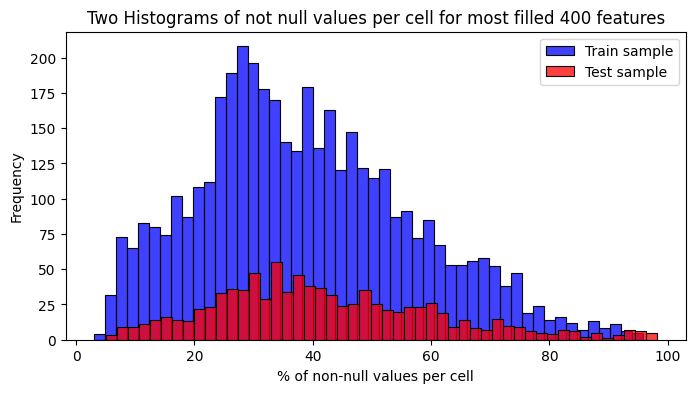

In [95]:
# What is so different between small and big datasets?
#sorted_columns_indices = np.argsort(non_zero_percent_per_column)[::-1]

top_400_columns = sorted_columns_indices[:400]
X_train_top_400 = X_train[:,top_400_columns]
non_zero_percent_per_row_400_train = np.count_nonzero(X_train_top_400, axis = 1)/400 * 100

X_test_top_400 = X_test[:,top_400_columns]
non_zero_percent_per_row_400_test = np.count_nonzero(X_test_top_400, axis = 1)/400 * 100

# Create a Seaborn figure with two histograms
plt.figure(figsize=(8, 4))  # Adjust the figure size as needed

# Plot the first histogram
sns.histplot(data=non_zero_percent_per_row_400_train, bins=50, color='blue', label='Train sample')


# Plot the second histogram on the same axes
sns.histplot(data=non_zero_percent_per_row_400_test, bins=50, color='red', label='Test sample')


# Add labels, legend, and other customizations
plt.xlabel('% of non-null values per cell')
plt.ylabel('Frequency')
plt.title('Two Histograms of not null values per cell for most filled 400 features')
plt.legend()

plt.show()

In [100]:
sorted_columns_indices[:6]

array([153294,  86775,  97920, 221775,  55713, 134906])

Text(0.5, 1.0, '134906 6')

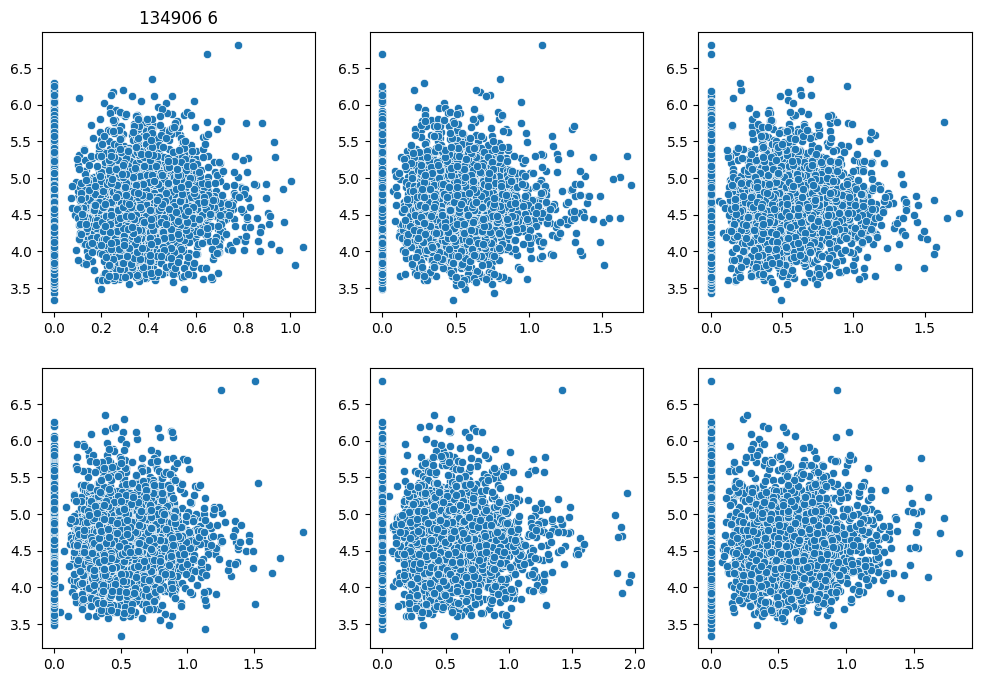

In [103]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
sns.scatterplot(x = X_train[:,153294], y = y_train, ax=axes[0, 0])
axes[0, 0].set_title('153294 1')

sns.scatterplot(x = X_train[:,86775], y = y_train, ax=axes[0, 1])
axes[0, 0].set_title('86775 2')
sns.scatterplot(x = X_train[:,97920], y = y_train, ax=axes[0, 2])
axes[0, 0].set_title('97920 3')
sns.scatterplot(x = X_train[:,221775], y = y_train, ax=axes[1, 0])
axes[0, 0].set_title('221775 4')
sns.scatterplot(x = X_train[:,55713], y = y_train, ax=axes[1, 1])
axes[0, 0].set_title('55713 5')
sns.scatterplot(x = X_train[:,134906], y = y_train, ax=axes[1, 2])
axes[0, 0].set_title('134906 6')


Text(0.5, 1.0, 'test 2')

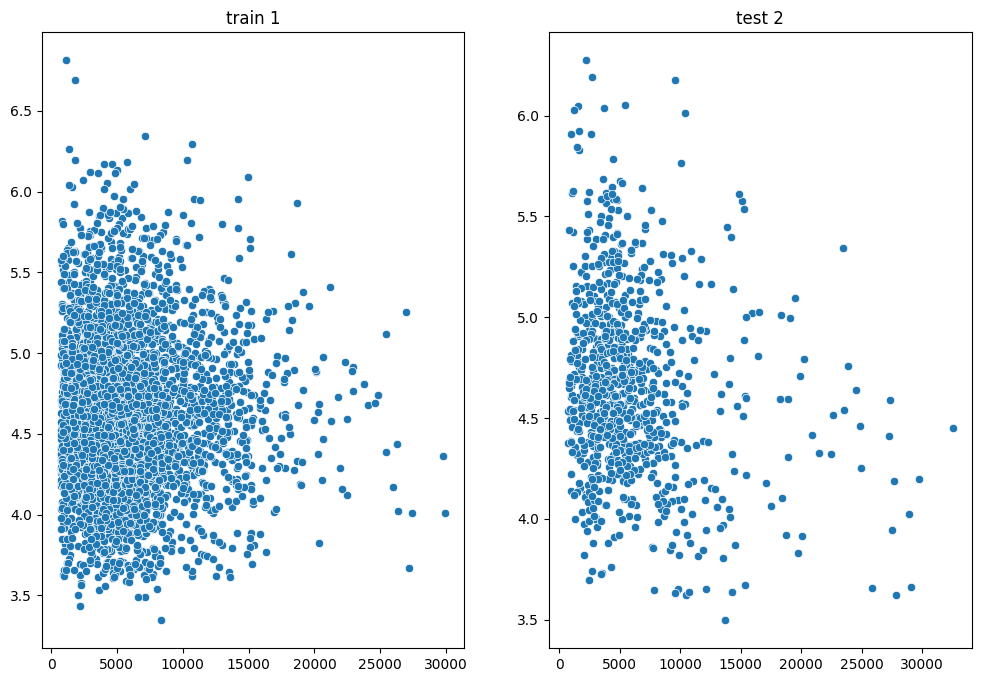

In [133]:
non_zero_count_per_row = np.count_nonzero(X_train, axis = 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
sns.scatterplot(x = non_zero_count_per_row, y = y_train, ax=axes[0])
axes[0].set_title('train 1')
non_zero_count_per_row = np.count_nonzero(X_test, axis = 1)
sns.scatterplot(x = non_zero_count_per_row, y = y_test, ax=axes[1])
axes[1].set_title('test 2')

In [130]:
np.corrcoef(non_zero_count_per_row,y_train)

array([[ 1.        , -0.01192194],
       [-0.01192194,  1.        ]])

In [104]:
start_time = time.time()
corr_ = [np.corrcoef(X_train[:,i], y_train)[0, 1] for i in range(228942)]

print("--- %s seconds ---" % (time.time() - start_time))

/home/skovtun/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/skovtun/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


NameError: name 'corr_10024' is not defined

In [108]:
corr_20 = [x for x in corr_ if x > 0.05]
print(len(corr_20))

220


In [112]:
# The next idea is to apply tree based method for feature selection:
from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier
top_5000_columns = sorted_columns_indices[:5000]
X_train_top_5000 = X_train[:,top_5000_columns]
model = RandomForestRegressor(n_jobs = -1)  # or RandomForestClassifier
time_start = time.time()
model.fit(X_train_top_5000, y_train)
feature_importances = model.feature_importances_
feature_ranking = np.argsort(feature_importances)[::-1]
k = 100  # Number of top features to select
selected_features = feature_ranking[:k]
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]
print("--- %s seconds ---" % (time.time() - start_time))
# It takes way too much time for whole 222000. 
#Let's do the same but initially reduce number of feature to 5000 most filled.
#--- 4721.187408924103 seconds --- still way too long to reproduce for 20000 targets.

--- 4721.187408924103 seconds ---


In [119]:
feature_importances[1133]

0.001321755652960369

In [115]:
selected_features[:6]

array([3456, 1133, 2639, 1707,  790, 1367])

Text(0.5, 1.0, '1367 6')

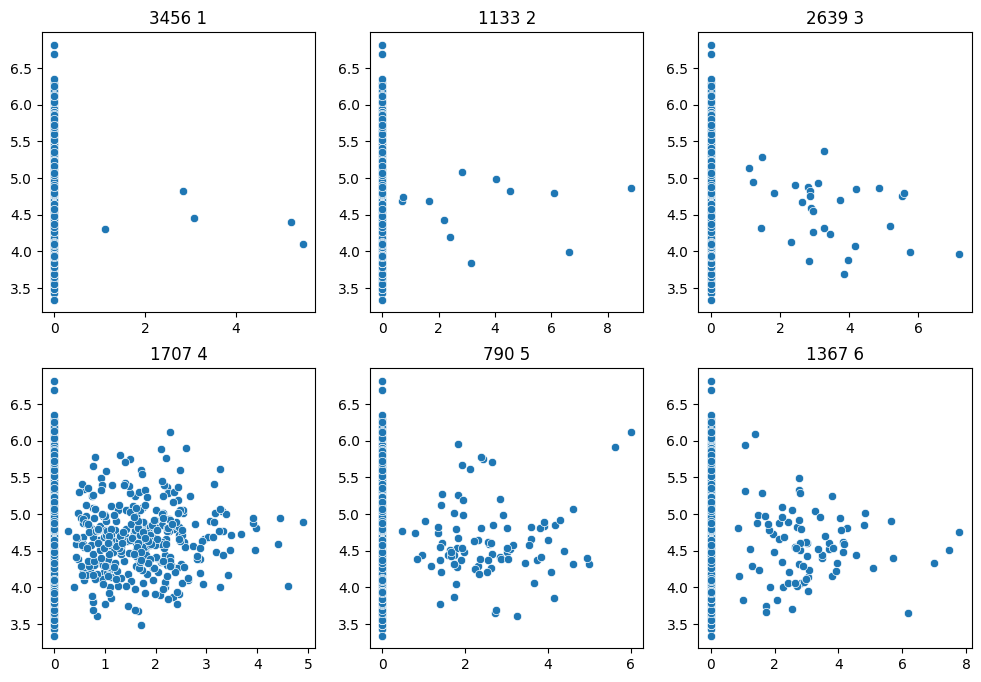

In [117]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
sns.scatterplot(x = X_train[:,3456], y = y_train, ax=axes[0, 0])
axes[0, 0].set_title('3456 1')

sns.scatterplot(x = X_train[:,1133], y = y_train, ax=axes[0, 1])
axes[0, 1].set_title('1133 2')
sns.scatterplot(x = X_train[:,2639], y = y_train, ax=axes[0, 2])
axes[0, 2].set_title('2639 3')
sns.scatterplot(x = X_train[:,1707], y = y_train, ax=axes[1, 0])
axes[1, 0].set_title('1707 4')
sns.scatterplot(x = X_train[:,790], y = y_train, ax=axes[1, 1])
axes[1, 1].set_title('790 5')
sns.scatterplot(x = X_train[:,1367], y = y_train, ax=axes[1, 2])
axes[1, 2].set_title('1367 6')


In [ ]:
start_time = time.time()
# Create an instance of XGBRegressor
xgb_model = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based')
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=3)

# Define the parameter grid for GridSearchCV
param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.075,0.5, 1],
    #'min_child_weight': [1, 3, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [1, 5, 100],
    'reg_lambda': [1, 5, 100]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error',verbose = 2)

# Fit the GridSearchCV instance on the data
grid_search.fit(X_train_selected, y_train)

# Print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the train set
y_pred = best_model.predict(X_train_selected)

# Calculate the pearson correlation on the train set
pe = scipy.stats.pearsonr(y_train, y_pred)
print("Pearson Error on train set:", pe)
print("--- %s seconds ---" % (time.time() - start_time))
# Best parameters: {'learning_rate': 1, 'reg_alpha': 100, 'reg_lambda': 1}
# Pearson Error on train set: PearsonRResult(statistic=0.08225543014728322, pvalue=9.255521826014361e-08)
# --- 17.840510845184326 seconds ---

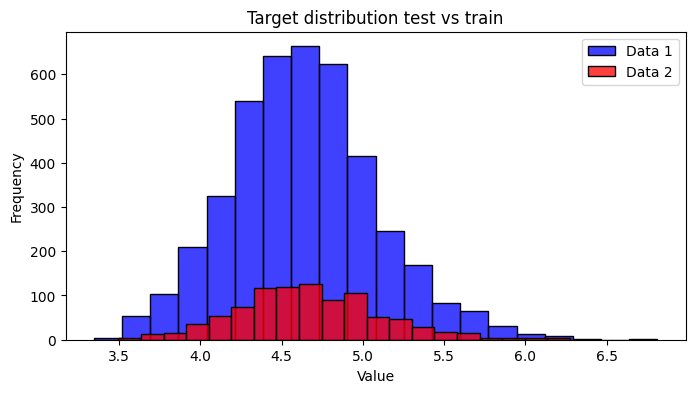

In [ ]:
# What is so different train vs sample?
# Let's   compare distribution of several features.

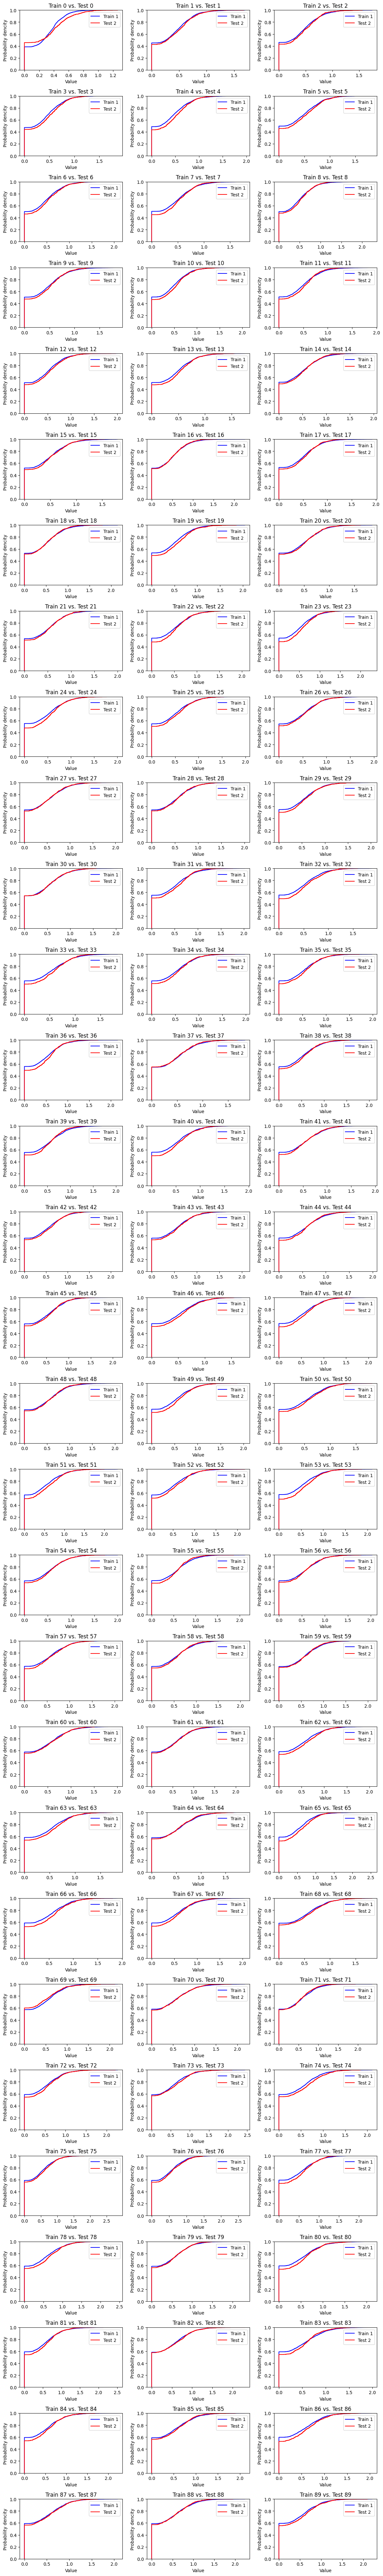

In [167]:

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

X_test_datasets = [X_test[:,i] for i in sorted_columns_indices[:90]]
X_train_datasets = [X_train[:,i] for i in sorted_columns_indices[:90]]

# Create a grid of subplots
fig, axes = plt.subplots(30, 3, figsize=(12, 80))

# Iterate through pairs of datasets and plot cumulative distributions
for i, ax in enumerate(axes.ravel()):
    
    data1, data2 = X_train_datasets[i], X_test_datasets[i]
    sns.ecdfplot(data=data1, color='blue', label='Train 1', ax=ax)
    sns.ecdfplot(data=data2, color='red', label='Test 2', ax=ax)
    ax.set_xlabel('Value')
    ax.set_ylabel('Probability dencity')
    ax.set_title(f'Train {i} vs. Test {i}')
    ax.legend()

# Add spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


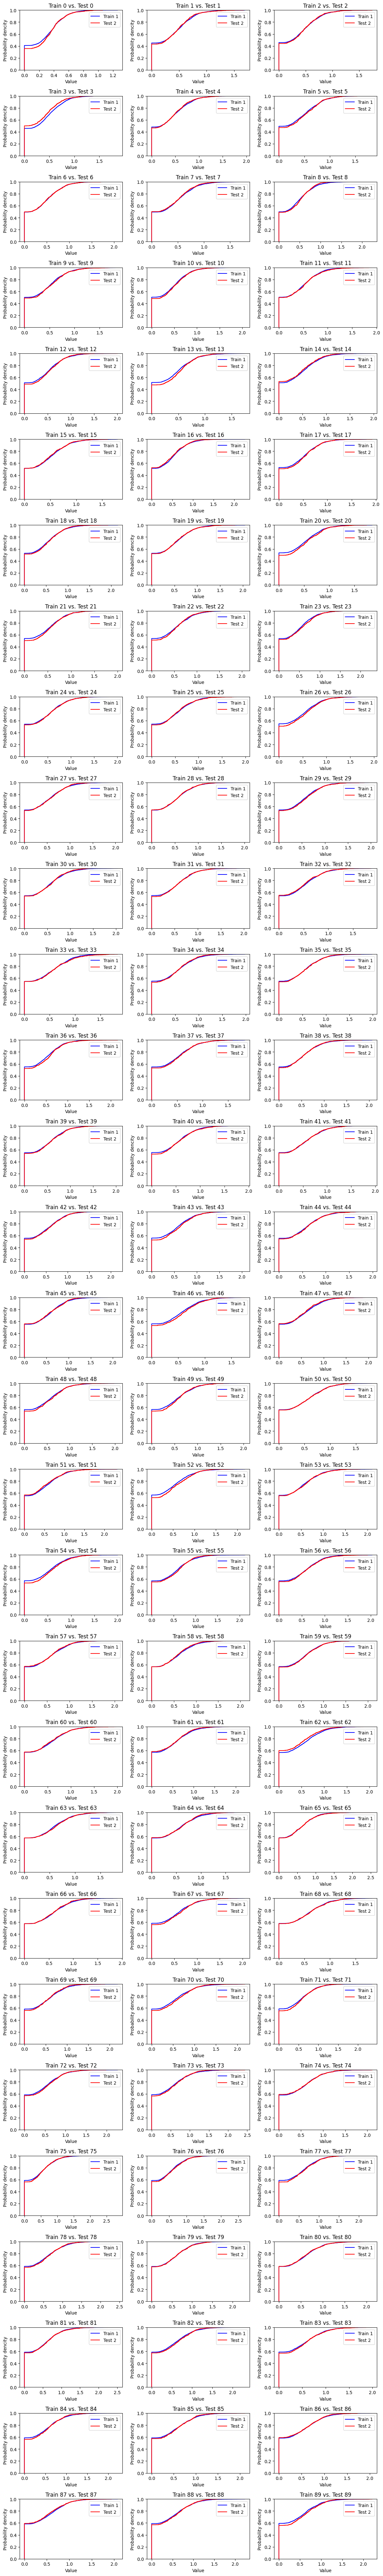

In [169]:
X = np.concatenate((X_test, X_train), axis = 0)
y = np.concatenate((y_test,y_train), axis = 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_datasets = [X_train[:,i] for i in sorted_columns_indices[:90]]
X_test_datasets = [X_test[:,i] for i in sorted_columns_indices[:90]]

# Create a grid of subplots
fig, axes = plt.subplots(30, 3, figsize=(12, 80))

# Iterate through pairs of datasets and plot cumulative distributions
for i, ax in enumerate(axes.ravel()):
    
    data1, data2 = X_train_datasets[i], X_test_datasets[i]
    sns.ecdfplot(data=data1, color='blue', label='Train 1', ax=ax)
    sns.ecdfplot(data=data2, color='red', label='Test 2', ax=ax)
    ax.set_xlabel('Value')
    ax.set_ylabel('Probability dencity')
    ax.set_title(f'Train {i} vs. Test {i}')
    ax.legend()

# Add spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [171]:
non_zero_count_per_row_X = np.count_nonzero(X, axis = 1)
non_zero_count_per_row_X_train = np.count_nonzero(X_train, axis = 1)
non_zero_count_per_row_X_test = np.count_nonzero(X_test, axis = 1)

In [ ]:
# Check that the parameters for XGBRegression are the same

In [157]:
sorted_columns_indices[:15]

array([153294,  86775,  97920, 221775,  55713, 134906, 128389,  76154,
       224677,  80864,   3165,  83325,  40121,  80381, 203127])

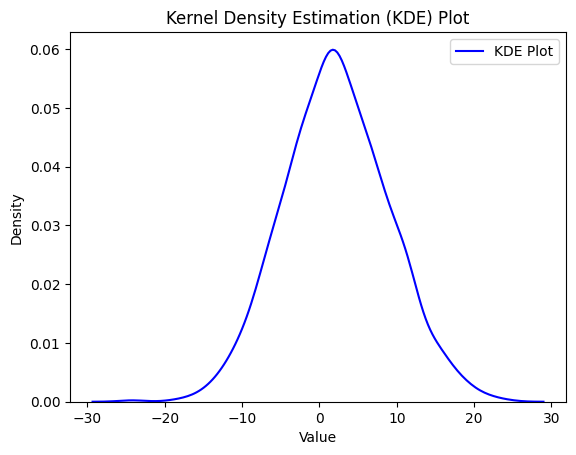

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = np.random.normal(2, 7, 1000)
sns.kdeplot(data=data, color='blue',  label='KDE Plot')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Kernel Density Estimation (KDE) Plot')
plt.legend()
plt.show()

In [ ]:
# Repeat the previous 5 items with 20 and 30 most relevant columns

In [139]:
start_time = time.time()
feat_not_null = [sum(X_14096[:,i] !=0) for i in range(X_14096.shape[1] )]
print("--- %s seconds ---" % (time.time() - start_time))

--- 18.943912267684937 seconds ---


In [140]:
start_time = time.time()
feat_not_null = [np.count_nonzero(X_14096[:,i]) for i in range(X_14096.shape[1] )]
print("--- %s seconds ---" % (time.time() - start_time))


--- 1.0528972148895264 seconds ---


Text(0.5, 1.0, 'Histogram of not null number of rows in a feature')

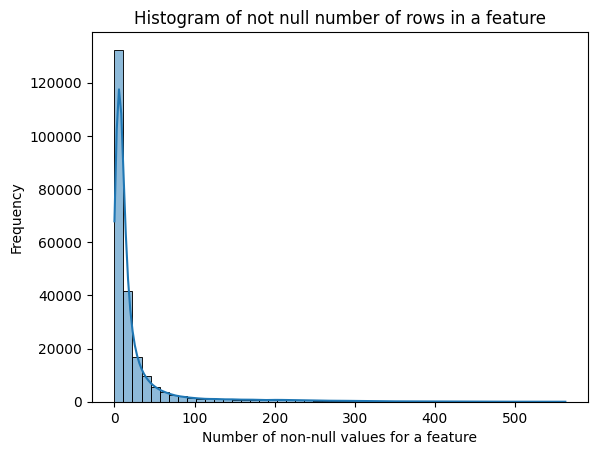

In [143]:
sns.histplot(feat_not_null, bins=50, kde=True)  # 'bins' controls the number of bins, 'kde' adds a kernel density estimation plot

# Add labels and a title
plt.xlabel("Number of non-null values for a feature")
plt.ylabel("Frequency")
plt.title("Histogram of not null number of rows in a feature")


In [154]:
top_10_values

array([563, 555, 547, 545, 541, 539, 538, 529, 521, 519])

In [158]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# Get the indexes that would sort the array in descending order
sorted_indexes = np.argsort(feat_not_null)[::-1]

# Get the values corresponding to the top 10 indexes
top_10_values = np.array(feat_not_null)[sorted_indexes[:10]]
top_10_indexes = sorted_indexes[:10]
X_14096_train = X_14096[:,top_10_indexes]
y_1496_train = y[indices_target,14096]

start_time = time.time()
# Create an instance of XGBRegressor
xgb_model = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based')
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=3)

# Define the parameter grid for GridSearchCV
param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.5],
    #'min_child_weight': [1, 3, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [1, 5, 100],
    'reg_lambda': [1, 5, 100]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error',verbose = 3)

# Fit the GridSearchCV instance on the data
grid_search.fit(X_14096_train, y_1496_train)

# Print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the train set
y_pred = best_model.predict(X_14096_train)

# Calculate the mean squared error on the train set
pe = scipy.stats.pearsonr(y_1496_train, y_pred)
print("Pearson Error on test set:", pe)
print("--- %s seconds ---" % (time.time() - start_time))

# Best parameters: {'learning_rate': 0.1, 'reg_alpha': 5, 'reg_lambda': 100}
# Pearson Error on test set: PearsonRResult(statistic=0.5829453175841457, pvalue=5.234661725078689e-89)
# --- 7.926203727722168 seconds ---
# Next step is to see if we get more accuracy with more features.

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.182 total time=   0.2s
[CV 2/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.216 total time=   0.1s
[CV 3/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.200 total time=   0.1s
[CV 4/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.255 total time=   0.1s
[CV 5/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.206 total time=   0.1s
[CV 1/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.176 total time=   0.1s
[CV 2/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.209 total time=   0.2s
[CV 3/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.199 total time=   0.1s
[CV 4/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.253 total time=   0.1s
[CV 5/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.200 total time=   0.1s
[CV 1/5] END learni

In [ ]:
# Get the indexes that would sort the array in descending order
sorted_indexes = np.argsort(feat_not_null)[::-1]

# Get the values corresponding to the top 20 indexes
top_20_values = np.array(feat_not_null)[sorted_indexes[:20]]
top_20_indexes = sorted_indexes[:20]
X_14096_train = X_14096[:,top_20_indexes]
y_1496_train = y[indices_target,14096]

start_time = time.time()
# Create an instance of XGBRegressor
xgb_model = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based')
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=3)

# Define the parameter grid for GridSearchCV
param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.5],
    #'min_child_weight': [1, 3, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [1, 5, 100],
    'reg_lambda': [1, 5, 100]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error',verbose = 3)

# Fit the GridSearchCV instance on the data
grid_search.fit(X_14096_train, y_1496_train)

# Print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the train set
y_pred = best_model.predict(X_14096_train)

# Calculate the mean squared error on the train set
pe = scipy.stats.pearsonr(y_1496_train, y_pred)
print("Pearson Error on test set:", pe)
print("--- %s seconds ---" % (time.time() - start_time))

# Best parameters: {'learning_rate': 0.1, 'reg_alpha': 5, 'reg_lambda': 100}
# Pearson Error on test set: PearsonRResult(statistic=0.681957300629006, pvalue=4.133401202661129e-133)
# --- 8.606647491455078 seconds ---
# We do getting more accuracy using more data. Let's see what happens if we use 30.

In [160]:
# Get the indexes that would sort the array in descending order
sorted_indexes = np.argsort(feat_not_null)[::-1]

# Get the values corresponding to the top 20 indexes
top_30_values = np.array(feat_not_null)[sorted_indexes[:30]]
top_30_indexes = sorted_indexes[:30]
X_14096_train = X_14096[:,top_30_indexes]
y_14096_train = y[indices_target,14096]

start_time = time.time()
# Create an instance of XGBRegressor
xgb_model = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based')
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=3)

# Define the parameter grid for GridSearchCV
param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.5],
    #'min_child_weight': [1, 3, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [1, 5, 100],
    'reg_lambda': [1, 5, 100]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error',verbose = 3)

# Fit the GridSearchCV instance on the data
grid_search.fit(X_14096_train, y_14096_train)

# Print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the train set
y_pred = best_model.predict(X_14096_train)

# Calculate the mean squared error on the train set
pe = scipy.stats.pearsonr(y_14096_train, y_pred)
print("Pearson Error on test set:", pe)
print("--- %s seconds ---" % (time.time() - start_time))

# Best parameters: {'learning_rate': 0.1, 'reg_alpha': 5, 'reg_lambda': 100}
# Pearson Error on test set: PearsonRResult(statistic=0.7347193028601066, pvalue=1.1964323780237837e-164)
# --- 9.407515525817871 seconds ---
# Not such big improvement as in previlous case, but still better. Let's analyse how much data have
# features that are in the first 30.

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.175 total time=   0.2s
[CV 2/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.200 total time=   0.2s
[CV 3/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.195 total time=   0.2s
[CV 4/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.253 total time=   0.2s
[CV 5/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.224 total time=   0.2s
[CV 1/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.177 total time=   0.2s
[CV 2/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.196 total time=   0.2s
[CV 3/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.192 total time=   0.2s
[CV 4/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.234 total time=   0.2s
[CV 5/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.220 total time=   0.2s
[CV 1/5] END learni

In [163]:
# Get the values corresponding to the top 10 indexes
np.array(feat_not_null)[sorted_indexes[:50]]

array([563, 555, 547, 545, 541, 539, 538, 529, 521, 519, 517, 509, 509,
       508, 507, 507, 505, 505, 502, 501, 501, 500, 500, 497, 496, 495,
       494, 493, 493, 492, 492, 488, 487, 484, 481, 481, 481, 480, 477,
       475, 474, 474, 474, 472, 471, 470, 470, 468, 467, 465])

In [190]:
# Let's see how many non-null target values we have at all 
target = h5py.File(train_multi_targets,'r')#, mode)
target_train_14096 = target['train_multi_targets']['block0_values'][:,14096]
indices_target_14096 = [i for i,x in enumerate(target_train_14096) if x != 0]
target_14096 = target_train_14096[indices_target_14096]

In [193]:
Xm_train = h5py.File(train_multi_inputs,'r')
time_start = time.time()
train_14096 = Xm_train['train_multi_inputs']['block0_values'][indices_target_14096,:]
print("--- %s seconds ---" % (time.time() - start_time))
#--- 22983.674932718277 seconds ---

--- 22983.674932718277 seconds ---


In [172]:
np.count_nonzero(target_train_14096)
# So, we have 5130 cells in wich target for 14096 RNK fragmen has not null value.
# Our next task is to read rows with all the features for the same cells
# My main question is, can I use just the row number or should I use cell_id to get them?


In [181]:
Xm_train = h5py.File(train_multi_inputs,'r')
cell_id_train = Xm_train['train_multi_inputs']['axis1']
cell_id_target = target['train_multi_targets']['axis1']
print(cell_id_train[:5], cell_id_target[:5])
print(cell_id_train == cell_id_target)

[b'56390cf1b95e' b'fc0c60183c33' b'9b4a87e22ad0' b'81cccad8cd81'
 b'15cb3d85c232'] [b'56390cf1b95e' b'fc0c60183c33' b'9b4a87e22ad0' b'81cccad8cd81'
 b'15cb3d85c232']
False


In [184]:
#print(len(cell_id_train), len(cell_id_target))
for index, (elem1, elem2) in enumerate(zip(cell_id_train, cell_id_target)):
    if elem1 != elem2:
        print(f"The first differing element is at index {index}: {elem1} (cell_id_train) vs {elem2} (cell_id_target)")
        break
else:
    print("The lists are identical.")

The lists are identical.


In [185]:
t_cell_id_train = tuple(cell_id_train)
t_cell_id_target = tuple(cell_id_target)
t_cell_id_target == t_cell_id_train

True

So the lists of cell_id in train_multi_inputs and train_multi_targets are identical.
This means we can ignore cell_id and just use row number in the corresponding data tables.

In [ ]:
Xm_train = h5py.File(train_multi_inputs,'r')
time_start = time.time()
train_14096 = Xm_train['train_multi_inputs']['block0_values'][indices_target_14096,:]
print("--- %s seconds ---" % (time.time() - start_time))
#--- 22983.674932718277 seconds ---

In [ ]:
#Lets find 50 features with the most infomration and see if they are the same as in 20000 sample.
# Split on test and train
# Tune hyperparemeters in XGBRegressor
# Build model
# verify on test

In [194]:
start_time = time.time()
feat_not_null_14096 = [np.count_nonzero(train_14096[:,i]) for i in range(train_14096.shape[1] )]
print("--- %s seconds ---" % (time.time() - start_time))


--- 11.617905139923096 seconds ---


In [5]:
loaded_svd_pipeline = joblib.load('svd_model_10500_6000.joblib')
X = loaded_svd_pipeline.transform(sampled_sparse_matrix1)
target = h5py.File(train_multi_targets,'r')#, mode)
y = target['train_multi_targets']['block0_values'][first_sample_indices,:]

For indices in our random samples of observations we need to get corresponding cell_ids

In [12]:
sample_cell_id

array([b'a7791bcf1152', b'00f283126092', b'e31ca103a4ac', ...,
       b'd702b0ffa5f4', b'69451694ec4c', b'553bca99ba78'], dtype='|S12')

In [49]:
ids = [i.decode('UTF-8') for i in sample_cell_id]

Using cell id get day and donor_id from metadata

In [54]:
metadata_df = pd.read_csv(metadata)
mult = metadata_df[metadata_df['technology'] == 'multiome'].drop('technology', axis=1)

In [55]:
# To make the result in the same order as in sample_cell_id
# Convert 'cell_id' to categorical with custom order
mult['cell_id'] = pd.Categorical(mult['cell_id'], categories=ids, ordered=True)
# Filtering using isin()
mult_f = mult[mult['cell_id'].isin(ids)]